In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os

# 0.1 General Helpers: 

In [5]:
def print_df(df: pd.DataFrame):
    """printing data in table for easy readable in console output.

    Args:
        df (pd.DataFrame): any Dataframe for visualization
    """
    
    df.columns = df.columns.str.replace(' ', '')
    
    # Determine column width (including index)
    widths = [max(len("t"), 10)] + [max(len(str(x)), 20) for x in df.columns]

    # Center header (including “Index” as column index)
    header = " | ".join(str(col).center(width) for col, width in zip(["t"] + list(df.columns), widths))

    # Center values (including row index)
    rows = "\n".join(
    " | ".join(str(val).center(width) for val, width in zip([index] + list(row), widths))
    for index, row in zip(df.index, df.values)
    )

    # Merge and output
    print(header)
    print("-" * len(header))  # Dividing line
    print(rows)
    
    
def change_energy_units(
    values: list, 
    actual_unit: str, 
    target_unit: str):
    """Iterates through a list of values (int/float) and checks unit. If actual and target units differ it processes 
    all values into new unit and gives back new list as return value.

    Args:
        values (list): power or energy values
        actual_unit (str): actual unit of input values
        target_unit (str): target unit for values

    Returns:
        list: target values with intended target unit.
    """
    target_values = []
    # Permitted units
    kW_units = ['kW', 'kWh']
    MW_units = ['MW', 'MWh']
    GW_units = ['GW', 'GWh']
    for value in values: 
        if actual_unit in kW_units and target_unit in MW_units: 
            target_values.append(round((value / 1000),2))
        elif actual_unit in kW_units and target_unit in GW_units:
            target_values.append(round((value / 1000000),2))
        elif actual_unit in kW_units and target_unit in kW_units:
            target_values.append(round((value),2))
        elif actual_unit in MW_units and target_unit in GW_units:
            target_values.append(round((value / 1000),2))
        elif actual_unit in MW_units and target_unit in kW_units:
            target_values.append(round((value * 1000),2))
        elif actual_unit in MW_units and target_unit in MW_units:
            target_values.append(round((value),2))
        elif actual_unit in GW_units and target_unit in MW_units:
            target_values.append(round((value * 1000),2))
        elif actual_unit in GW_units and target_unit in kW_units:
            target_values.append(round((value * 1000000),2))
        elif actual_unit in GW_units and target_unit in GW_units:
            target_values.append(round((value),2))
        else: 
            raise KeyError("Unit not found. Check spelling or add unit in function.")
    # print(f"Calculation done for actual unit: {actual_unit} to target unit: {target_unit}")
    return target_values


def get_weeks_from_timestamp(
    timestamps: list
    ):
    """generates weeks from input-dates by cutting string and find out KW. Result is a list of Strings. 
    Useful for plotting diagrams based on weeks and not months.

    Args:
        timestamps (list): list of timestamps in format: ['YYYY-MM-DD/YYYY-MM-DD', ...] if weeks are set as granularity.

    Returns:
        list: list with strings of weeknumber [01, 02, 03, ...] based on startdate (suitbale for x axis)
    """
    weeks = []
    for timestamp in timestamps:
        start_str = timestamp.split('/')[0]  # note only the start value before the '/'
        # Convert start date to datetime
        start_date = datetime.strptime(
            start_str, 
            "%Y-%m-%d"
            )
        # Retrieve calendar week
        start_week = start_date.isocalendar()[1]
        weeks.append(start_week)
        
    return weeks


def get_months_from_timestamp(
    timestamps: list
    ):
    """Adjust the strings contained by default for the month, 
    by deleting the year and leaving only the month as a string.

    Args:
        timestamps (list): input timestamps in list ['YYYY-MM', ...]

    Returns:
        list: converted list with months as strings
    """
    months = []
    for timestamp in timestamps:
        year = timestamp[:4]
        months.append(timestamp.replace(f'{year}-', ''))

    return months

## 0.2 Load data from csv output:

In [6]:
def load_csv_results_in_df(
    input_path: str
    ):
    """Load output csv in dataframe.

    Args:
        input_path (str): path from which csv is loaded. 

    Returns:
        pd.DataFrame: csv data in dataframe as table type.
    """
    input_values_df = pd.read_csv(
        input_path, 
        index_col=0
        )
    return input_values_df

# 1 Functions for filtering and extracting values

In [10]:
def add_timestamp_and_filter(
    input_df: pd.DataFrame, 
    start_time: str, 
    end_time: str, 
    time_column = 'date'
    ):
    """Insert Dates (YYYY-MM-DD HH:MM) in DataFrame and filter after given start and end date.
    Assumption: 8784 values (366 days) beginning at 01.01.2025.

    Args:
        df (pd.DataFrame, optional): Input Dataframe from output. Defaults to pd.DataFrame.
        start_time (str, optional): first date and time for filtering. Defaults to str.
        end_time (str, optional): end date and time for filtering. Defaults to str.
        time_column (str, optional): name of column with time steps. Default value 'date'.

    Returns:
        pd.DataFrame: added colomn with dates and time, and filtered Dataframe after time span.
    """
    # Create List of dates and hours belonging to timestep:
    dates = list(
        pd.date_range(
            '2025-01-01 00:00', 
            periods=8784, #TODO: Funktion ermittlung periods normales und Schaltjahr einfügen!
            freq='H')
        )
    input_df.insert(
        0, 
        time_column, 
        dates, 
        allow_duplicates=False
        )
    input_df[time_column] = pd.to_datetime(input_df[time_column])
    # Delete blank spaces of colomn names:
    input_df.columns = input_df.columns.str.replace(' ', '')
    # filtered df after time span:
    return input_df[(input_df[time_column] >= pd.Timestamp(start_time)) & (input_df[time_column] <= pd.Timestamp(end_time))]

def extract_price_data_to_dict(
    time_filtered_df: pd.DataFrame, 
    assets: tuple,
    key_gas_price: str,
    key_power_price: str
    ):
    """
    Reads certain price and CO2 columns belonging to relevant assets for the diagram from a DataFrame 
    and saves them in a dictionary.

    Parameters:
        time_filtered_df (pd.DataFrame): filtered DataFrame by time.
        assets (tuple): A tuple with all assets that are to be displayed.
        key_gas_price (str): String for gas price column in csv file. 
        key_power_price (str): String for power price column in csv file. 

    Returns:
        extracted_columns_dict: Dictionary with asset name and variable as keys and belonging hourly data for set timespan as lists (= value).
    """
    # Generate the complete column names
    column_names = [key_gas_price, key_power_price] # convert input data for price names in list
    for asset in assets:   
        column_names.append(str(f"{asset}.co2")) # get keys of set assets in input data emitting co2 
        column_names.append(str(f"{asset}.power"))
        column_names.append(str(f"{asset}.gas"))
    print("column names: ", column_names)
    # Filter the desired columns:
    extracted_columns_dict = {col: list(time_filtered_df[col]) for col in column_names if col in time_filtered_df.columns}
    return extracted_columns_dict

def get_time_data_for_plot(
    time_filtered_df: pd.DataFrame, 
    granularity: str, 
    time_column='date'
): 
    """
    Generates time values for the x-axis depending on the selected granularity:
    - Hourly values as timestamps (always included)
    - If desired: monthly figures, calendar weeks or daily values (day & month)

    Args:
        time_filtered_df (pd.DataFrame): Time-filtered DataFrame with timestamps as index.
        granularity (str): 'hour', 'day', 'week' oder 'month'.
        time_column (str, optional): name of column with timestamps. Default: 'date'.

    Returns:
        tuple: (Hourly timestamps, dict with values for the x-axis based on granularity)
    """
    # Ensure that the index is set as datetime
    time_filtered_df = time_filtered_df.copy()
    time_filtered_df[time_column] = pd.to_datetime(time_filtered_df[time_column])
    time_filtered_df.set_index(time_column, inplace=True)
    # hourly timestamps (always contained))
    hourly_timestamps = time_filtered_df.index.to_list()
    # X-axis ticks dependant on set granularity
    first_occurrences_dict = {}
    if granularity == 'hour':
        for i, ts in enumerate(hourly_timestamps):
            hour = ts.strftime('%Y-%m-%d %H:%M')  # Extract the hour and minute (e.g. “14:30”)
            first_occurrences_dict[hour] = i
    elif granularity == 'day':
        # Identify the first timestamp of each day
        for i, ts in enumerate(hourly_timestamps):
            day = ts.strftime('%d-%m')  # Extract the date without time
            if day not in first_occurrences_dict:
                first_occurrences_dict[day] = i  # Save the index of the first occurrence
    
    elif granularity == 'week':
        # get week of calendar as number (1-53)
        for i, ts in enumerate(hourly_timestamps):
            week = f"KW {ts.strftime('%U')}"  # Extract the date without time
            if week not in first_occurrences_dict:
                first_occurrences_dict[week] = i  # Save the index of the first occurrence
    
    elif granularity == 'month': 
        # extract month as number (1-12)
        for i, ts in enumerate(hourly_timestamps):
            month = ts.strftime('%m')  # Extract the date without time
            if month not in first_occurrences_dict:
                first_occurrences_dict[month] = i  # Save the index of the first occurrence
    else: 
        raise ValueError(f"Granularity '{granularity}' not known. Please use 'hour', 'day', 'week', or 'month'.")
    return hourly_timestamps, first_occurrences_dict

# example execution: 
INPUT_PATH = "../data/output/gee23_ST-min_NW-ref_2028_output_cleaned.csv"
df = load_csv_results_in_df(input_path=INPUT_PATH)
START_DATE = "2025-06-01 00:00"
END_DATE = "2025-06-30 12:00"
filtered_df = add_timestamp_and_filter(df, START_DATE, END_DATE)
times, occurences = get_time_data_for_plot(
    time_filtered_df=filtered_df,
    granularity='day'
    )
print('times: ', times)
print('occurences: ', occurences)
    

times:  [Timestamp('2025-06-01 00:00:00'), Timestamp('2025-06-01 01:00:00'), Timestamp('2025-06-01 02:00:00'), Timestamp('2025-06-01 03:00:00'), Timestamp('2025-06-01 04:00:00'), Timestamp('2025-06-01 05:00:00'), Timestamp('2025-06-01 06:00:00'), Timestamp('2025-06-01 07:00:00'), Timestamp('2025-06-01 08:00:00'), Timestamp('2025-06-01 09:00:00'), Timestamp('2025-06-01 10:00:00'), Timestamp('2025-06-01 11:00:00'), Timestamp('2025-06-01 12:00:00'), Timestamp('2025-06-01 13:00:00'), Timestamp('2025-06-01 14:00:00'), Timestamp('2025-06-01 15:00:00'), Timestamp('2025-06-01 16:00:00'), Timestamp('2025-06-01 17:00:00'), Timestamp('2025-06-01 18:00:00'), Timestamp('2025-06-01 19:00:00'), Timestamp('2025-06-01 20:00:00'), Timestamp('2025-06-01 21:00:00'), Timestamp('2025-06-01 22:00:00'), Timestamp('2025-06-01 23:00:00'), Timestamp('2025-06-02 00:00:00'), Timestamp('2025-06-02 01:00:00'), Timestamp('2025-06-02 02:00:00'), Timestamp('2025-06-02 03:00:00'), Timestamp('2025-06-02 04:00:00'), Times

# 2. Calculate CSS: 

In [6]:
def calculate_css(
    price_dict: dict,
    key_gas_price: str,
    key_electr_price: str,
    P_co2: float,
    eta_el: float,
    alpha: float,
    beta: float
): 
    """_summary_

    Args:
        price_dict (dict): Dictionary with price data from csv. 
        key_gas_price (str): key of gas price for column in csv or key of price_dict. 
        key_electr_price (str): key of electricity revenue for column in csv or key of price_dict.
        P_co2 (float): key for price of Co2. Currently a constant. 
        eta_el (float): electric efficiency of power plant. 
        alpha (float): factor of calorific value.
        beta (float): factor of natural gas. 

    Raises:
        KeyError: Error if necessary price data is not in csv. Co2 needs to be added in condition!

    Returns:
        list: list of calculated css values for plot (y-axis)
    """
    if key_gas_price not in price_dict or key_electr_price not in price_dict:
        raise KeyError(f"[calculate_css] Keys {key_gas_price} or {key_electr_price} are missing in price_dict")
    # print("P_co2: ", P_co2)
    # print("eta_el: ", eta_el)
    # print("alpha: ", alpha)
    # print("beta: ", beta)
    css_values = []
    for P_power, P_gas in zip(price_dict[key_electr_price], price_dict[key_gas_price]): 
        css = P_power - (1/eta_el) * (alpha * P_gas + beta * P_co2) # formular calculation of CSS
        css_values.append(round(css, 2))
    # print("CSS: ", css_values)
    # print("Anzahl CSS werte", len(css_values))
    return css_values    

# 3 Plot economic data

In [7]:
def plot_css(
    y_values: list,
    x_values: list,
    granularity: str,
    x_axis_occurencies: dict, 
    title_size: str,
    fontsize: str, 
    colors_dict: dict, 
    other_cost_data: dict, 
    key_gas_price: str,
    key_power_price: str, 
    P_Co2: float
): 
    """Line chart plotting css in hourly granulation (ticks). Granularity of x axis is adjustable. 

    Args:
        y_values (list): css values to be plotted. 
        x_values (list): time data to be plotted. 
        granularity (str): wished granularity of x axis. 
        x_axis_occurencies (dict): occurencies to make sure that all time data is correct output on x axis.
        title_size (str): site of title font.
        fontsize (str): size of font in diagram.
        colors_dict (dict): dictionary with colors for set assets.
        other_cost_data (dict): Dictionary with other cost data than css.
        key_gas_price (str): key of gas price.
        key_power_price (str): key of power price.
        P_Co2 (float): constant of Co2 price.

    Returns:
        fig: Figure from matplotlib showing 4 types of cost data in one diagram as lines with different colors. 
    """
    
    labels = list(colors_dict.keys())
    # plotte CSS, Gas_price, Strompreis: 
    plt.style.use('dark_background') # dark Layout for slides
    fig, ax = plt.subplots(
        figsize=(16, 9), 
        facecolor="black"
        )
    ax.plot(
        x_values, 
        y_values, 
        marker=None, 
        linestyle='-', 
        label=labels[3], 
        color=colors_dict[labels[3]]
        )
    ax.plot(
        x_values, 
        other_cost_data[key_gas_price], 
        linestyle='-', 
        label=key_gas_price, 
        color=colors_dict[key_gas_price]
        )
    ax.plot(
        x_values, 
        other_cost_data[key_power_price], 
        linestyle='-', 
        label=key_power_price, 
        color=colors_dict[key_power_price]
        )
    # given constant, needs to be integrated as list 
    repeated_list = [P_Co2 for _ in range(len(x_values))]
    ax.plot(
        x_values, 
        repeated_list, 
        linestyle='-', 
        label=labels[2], 
        color=colors_dict[labels[2]]
        )
    # condition that more than 24 hours are plotted in one graph: 
    if granularity == 'hour': 
        ax.set_xticks([x_values[i] for i in x_axis_occurencies.values()])
        # Convert the complete date information to just “HH:MM” for the axis labeling
        ax.set_xticklabels(
            [key[-5:] for key in x_axis_occurencies.keys()],  # Schneidet nur "HH:MM" aus dem String
            rotation=45 
            )
    else: 
        ax.set_xticks(
        [x_values[i] for i in x_axis_occurencies.values()],  # reduce X values
        [tick for tick in x_axis_occurencies.keys()],  # set labels as granularity
        rotation=45 
        )
    # Setze Titel der Achsen. 
    ax.axhline(
        y=0, 
        color='white', 
        linewidth=0.7, 
        linestyle='-'
        )
    ax.set_xlabel(
        f"Time in {granularity}s", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    ax.set_ylabel(
        "Clean Spark Spread in €/MWh", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    ax.set_title(
        "Clean Spark Spread of scenario GEE23", 
        fontsize=title_size, 
        fontweight='bold', 
        y=1.1
        )
    ax.grid(
        True, 
        color='gray', 
        linestyle='--', 
        linewidth=0.5, 
        zorder=1
        )
    ax.tick_params(
        axis='x', 
        labelsize=fontsize
        ) 
    ax.tick_params(
        axis='y', 
        labelsize=fontsize
        )
    ax.legend(
        loc="lower center",           # position of legend
        bbox_to_anchor=(0.5, 1.0, 0, 0),   # anchor point (x=0.5 for central, y=1.0 for above)
        ncol=4,                      # amount of columns in legend
        frameon=True,                # Frame around legend
        fontsize=fontsize,
        title_fontsize=fontsize
        )

    # plt.show() # aktivieren, wenn nicht gespeichert wird. 
    return fig


def save_plot(
    fig, 
    output_path: str, 
    filename: str, 
    dpi: int = 300, 
    format: str = "png"
    ):
    """Saves the given plot in a file.

    Args:
        fig (matplotlib.figure.Figure): The diagram to be saved.
        output_path (str): Path to folder for saving file.
        filename (str): The file name (incl. path) for the saved file.
        dpi (int): The resolution of the picture.
        format (str): Data formate (f. e. "png", "pdf", "svg").
    """
    if not os.path.exists(output_path):
        os.makedirs(output_path)  # Erstelle den Ordner (und alle übergeordneten Ordner falls nötig)
    output_file = os.path.join(
        output_path, 
        filename
        )
    plt.savefig(
        output_file, 
        format=format, 
        dpi=dpi, 
        facecolor="black", 
        transparent=False
        )
    plt.show()
    plt.close(fig)
    print(f"Diagram saved as: {output_file}")

# Main script: 

## Input values: 

In [8]:

# 1 ! Definition Pathes, file and folder names for diagram:!
filename = 'css_0515.png'
output_folder_name = 'clean_spark_spread'
colors_filename = "assigned_colors.json"
INPUT_PATH = '../data/output/gee23_ST-min_NW-ref_2028_output_cleaned.csv'
OUTPUT_PATH = '../data/postprocessing/' + output_folder_name

# 2 ! time data: !
start_time = "2025-05-15 00:00" 
end_time = "2025-05-15 23:00"
granularity = 'hour'

# 3 ! asset data: !
my_assets = ('chp_1', 'chp_2') # only assets with co2 variable
key_gas_price = 'gas_price' # from csv
key_power_price = 'power_price' # from csv

# 4 ! Constant price parameter: !
P_CO2 = 76 # € / t
ETA_EL = 0.41
ALPHA = 1.107
BETA = 0.2016

# 5 Plot constants: 
title_size = 18
fontsize = 16

#TODO: set link to json soon.
# 6 set colors and keys of css and co2 price, manually (later load colors from same json as share of assets)
colors_dict = {
    "gas_price": [
        0.5843137255,
        0.3254901961,
        0.2784313725,
        1.0
    ],
    "power_price": [
        1.0, 
        0.85, 
        0.0, 
        1.0
    ],
    "Co2_price": [
        0.3882352941, 
        0.8470588235,
        0.2509803922,
        1.0
    ],
    "CSS": [
        0.2, 
        0.6, 
        1.0, 
        1.0
    ]
}

column names:  ['gas_price', 'power_price', 'chp_1.co2', 'chp_1.power', 'chp_1.gas', 'chp_2.co2', 'chp_2.power', 'chp_2.gas']
price dict:  {'gas_price': [29.731, 29.731, 29.731, 29.731, 29.731], 'power_price': [41.17, 41.17, 41.17, 41.17, 34.37], 'chp_1.co2': [0.0, 0.0, 0.0, 0.0, 0.0], 'chp_1.power': [0.0, 0.0, 0.0, 0.0, 0.0], 'chp_1.gas': [0.0, 0.0, 0.0, 0.0, 0.0], 'chp_2.co2': [0.0, 0.0, 0.0, 0.0, 0.0], 'chp_2.power': [0.0, 0.0, 0.0, 0.0, 0.0], 'chp_2.gas': [0.0, 0.0, 0.0, 0.0, 0.0]}
hourly_timestamps:  [Timestamp('2025-05-15 00:00:00'), Timestamp('2025-05-15 01:00:00'), Timestamp('2025-05-15 02:00:00'), Timestamp('2025-05-15 03:00:00'), Timestamp('2025-05-15 04:00:00')]
occurencies_dict:  {'2025-05-15 00:00': 0, '2025-05-15 01:00': 1, '2025-05-15 02:00': 2, '2025-05-15 03:00': 3, '2025-05-15 04:00': 4, '2025-05-15 05:00': 5, '2025-05-15 06:00': 6, '2025-05-15 07:00': 7, '2025-05-15 08:00': 8, '2025-05-15 09:00': 9, '2025-05-15 10:00': 10, '2025-05-15 11:00': 11, '2025-05-15 12:00': 

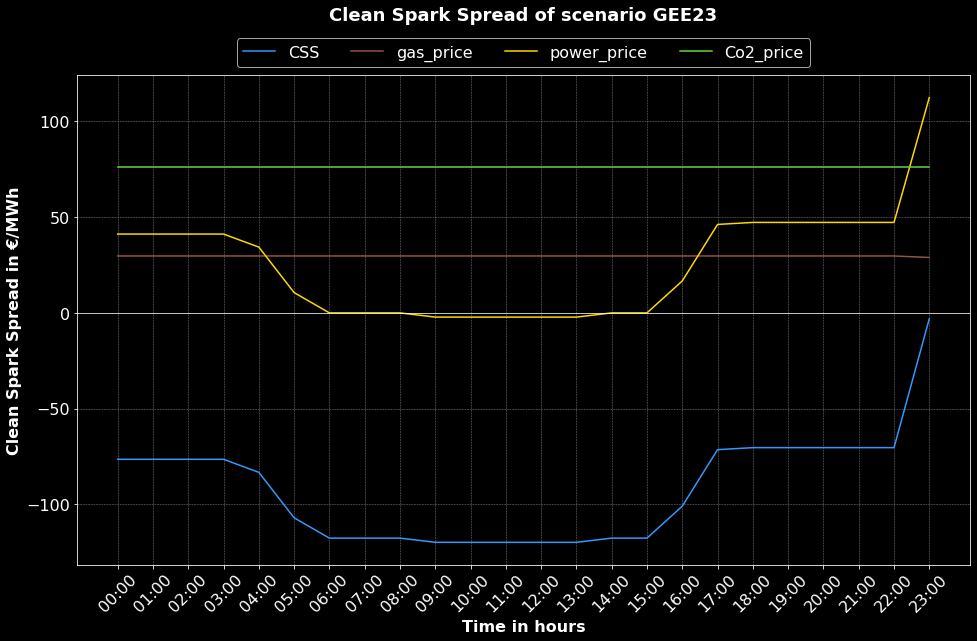

Diagram saved as: ../data/postprocessing/clean_spark_spread/css_0515.png


In [ ]:
if __name__ == "__main__":
    #TODO: kürzen in Wrapper!
    input_csv = load_csv_results_in_df(input_path=INPUT_PATH)
    df_with_time = add_timestamp_and_filter(
    input_df = input_csv, 
    start_time = start_time, 
    end_time = end_time, 
    time_column = 'date'
    )
    # print_df(df=df_with_time)
    price_dict = extract_price_data_to_dict(
    time_filtered_df = df_with_time, 
    assets = my_assets,
    key_gas_price = key_gas_price,
    key_power_price = key_power_price
    )
    trimmed_price_dict = {key: value[:5] for key, value in price_dict.items()}
    print("price dict: ", trimmed_price_dict)
    hourly_timestamps, occurencies_dict = get_time_data_for_plot(
        time_filtered_df=df_with_time,
        granularity=granularity
    )
    print("hourly_timestamps: ", hourly_timestamps[:5])
    print("occurencies_dict: ", occurencies_dict)
    css_values = calculate_css(
    price_dict = price_dict,
    key_gas_price = key_gas_price,
    key_electr_price = key_power_price,
    P_co2=P_CO2,
    eta_el = ETA_EL,
    alpha = ALPHA,
    beta = BETA)
    print("css_values: ", css_values[:5])
    fig = plot_css(
    y_values = css_values,
    x_values = hourly_timestamps,
    granularity = granularity,
    x_axis_occurencies =occurencies_dict,
    title_size=title_size,
    fontsize = fontsize, 
    colors_dict = colors_dict,
    other_cost_data = price_dict, 
    key_gas_price = key_gas_price, 
    key_power_price = key_power_price, 
    P_Co2 = P_CO2
    )
save_plot(
        fig=fig,
        output_path=OUTPUT_PATH,
        filename=filename 
    )